# 3. 멋진 단어사전 만들기 [프로젝트]
---

소설책 1권 분량의 텍스트를 lecture에서 다룬 다양한 기법으로 전처리하여 단어사전을 만들어 본다. <br>
각각의 단어사전을 토대로 language model을 생성하여 perplexity를 측정해 보고 어떤 기법의 성능이 우수한지 평가해 본다.

|평가문항|상세기준|
|:---|:---|
|1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?|	코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?|
|2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?|	SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.|
|3. SentencePiece의 성능을 다각도로 비교분석하였는가?|	SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.|

Step 1. SentencePiece 설치하기<br>
Step 2. SentencePiece 모델 학습<br>
Step 3. Tokenizer 함수 작성<br>
Step 4. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기


In [2]:
# 라이브러리 버전 확인
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

print(tf.__version__)     # 2.6.0
print(np.__version__)     # 1.21.4
print(plt.__version__)    # 3.4.3
print(konlpy.__version__) # 0.5.2

2.6.0
1.21.4
3.4.3
0.5.2


## Step 1. SentencePiece 설치
---
SentencePiece는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer 로서, BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것입니다. 아래 링크의 페이지에서 상세한 내용을 파악할 수 있습니다.

- [google/sentencepiece](https://github.com/google/sentencepiece)

위 페이지의 서두에서도 언급하고 있듯, SentencePiece는 딥러닝 자연어처리 모델의 앞부분에 사용할 목적으로 최적화되어 있는데, 최근 pretrained model들이 거의 대부분 SentencePiece를 tokenizer로 채용하면서 사실상 표준의 역할을 하고 있습니다.

다음과 같이 설치를 진행합니다. SentencePiece는 python에서 쓰라고 만들어진 라이브러리는 아니지만 편리한 파이썬 wrapper를 아래와 같이 제공하고 있습니다.

In [1]:
!pip install sentencepiece

## Step 2. SentencePiece 모델 학습
---
1. https://github.com/jungyeul/korean-parallel-corpora 데이터 사용
2. 정제된 corpus 구하기
3. SentencePiece 모델 학습

### 1. 데이터 다운로드

```bash
wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
mkdir -p ~/aiffel/sp_tokenizer/data
mv korean-english-park.train.tar.gz ~/aiffel/sp_tokenizer/data
cd ~/aiffel/sp_tokenizer/data
tar -xzvf korean-english-park.train.tar.gz
```


In [3]:
# 데이터 확인
import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size(문장 수):", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen) # "::": 스텝, 20번씩 건너뛰어서 출력 ~ sequence[start:stop:step]

Data Size(문장 수): 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [4]:
type(raw) # list
raw[0]    # '개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"'
print(raw[:3])

['개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"', '모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.', '그러나 이것은 또한 책상도 필요로 하지 않는다.']


문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


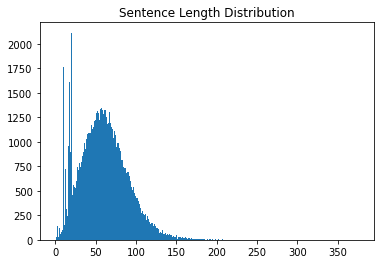

In [6]:
# 데이터 분포(문장길이 기준) 확인
import matplotlib.pyplot as plt

min_len = 999 
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length  # 최단길이 검색
    if max_len < length: max_len = length  # 최장길이 검색
    sum_len += length # 모든 문장의 길이 sum

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw)) # 평균길이 출력

sentence_length = np.zeros((max_len), dtype=int) # 각 인덱스에 문장 길이 저장을 위한 zero array

for sen in raw:
    sentence_length[len(sen)-1] += 1 # 해당 문장의 길이에 맞는 nparray 인덱스에 저장 후 카운팅.

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### 2. 데이터 전처리
1. 노이즈 확인
2. outlier 확인
3. 중복 제거
4. 문장 크기 결정

In [7]:
# 1) 노이즈 확인
def check_sentence_with_length(raw, length):
    '''
    길이별로 문장을 확인하는 함수. 
    raw : 문장 리스트
    length : 확인할 문장의 길이
    '''
    count = 0
    
    # raw(문장 리스트)에서 한 문장씩(sen) 가져와서 아래 수행
    for sen in raw:             
        if len(sen) == length:      # 전체 문장 하나씩 불러와서 맞는 길이 검색
            print(sen)              # 그 문장 출력
            count += 1              # 카운트.
            if count > 100: return  # 100개까지 출력

check_sentence_with_length(raw, 1)

’


In [8]:
# 2) outlier 확인

for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


In [9]:
check_sentence_with_length(raw, 11) #-> 중복

라고 조던이 말했다.
- 모르고 있습니다.
- 네, 보이는군요.
디즈니사만이 아니다.
큰 파티는 아니지요.
의자는 비어 있었다.
이 일은 계속됩니다.
나는 크게 실망했다.
그 이유는 간단하다.
이력서와 자기 소개서
시대가 변하고 있다.
는 돌발질문을 했다.
9. 몇 분간의 명상
하와이, 빅 아일랜드
키스를 잘 하는 방법
키스를 잘 하는 방법
스피어스가 뚱뚱한가?
산 위를 나는 느낌.
세 시간쯤 걸었을까?
(아직 읽고있습니까?
처음에는 장난이었다.
우리는 운이 좋았다.
아기가 숨을 멈출 때
건물 전체 무너져내려
그녀의 아름다운 눈.
대답은 다음과 같다.
"사과할 것이 없다.
폭탄테러가 공포 유발
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1

Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


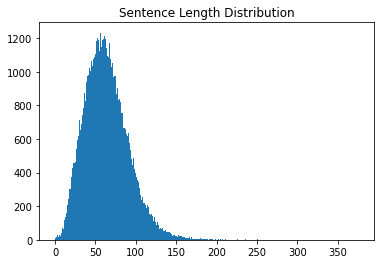

In [10]:
# 3) 중복 제거, 분포 확인
min_len = 999
max_len = 0
sum_len = 0

# 중복 제거
cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

# 데이터 분포 확인
for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

Data Size: 76908


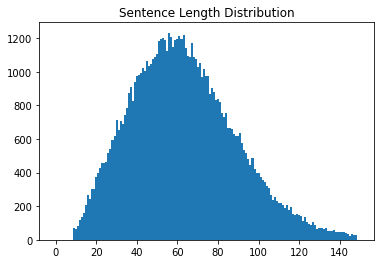

In [31]:
# 4) 사용할 문장 크기 결정

max_len = 150 # 최대 문장 길이
min_len = 10  # 최소 문장 길이

# 길이 조건에 맞는 문장만 선택합니다. cleaned_corpus -> set으로 중복제거한 문장 list
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]
print("Data Size:", len(filtered_corpus))

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### 3. SentencePiece 모델 학습

In [12]:
# SentencePiece 모델 학습

import sentencepiece as spm
import os

# 임시 파일 경로
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

# 임시파일 경로로 새 text 작성: row
with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

# SentencePiece 모델을 학습
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

# 'korean_spm'으로 시작하는 모든 파일 및 디렉토리의 상세 정보를 나열
!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 376816 Dec 27 23:30 korean_spm.model
-rw-r--r-- 1 root root 146213 Dec 27 23:30 korean_spm.vocab


-rw-r--r-- 1 root root 376816 Dec 27 23:30 korean_spm.model<br>
-rw-r--r-- 1 root root 146213 Dec 27 23:30 korean_spm.vocab

`korean_spm.model` 파일과 `korean_spm.vocab vocabulary` 파일이 생성되었음을 확인할 수 있습니다.



In [13]:
# 학습된 SentencePiece 모델 확인

s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1243, 11, 302, 7, 3608, 11, 287, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


## Step 3. Tokenizer 함수 작성
---
우리는 위에서 훈련시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 `sp_tokenize()` 함수를 정의할 겁니다. 하지만 SentencePiece가 동작하는 방식이 단순 토큰화와는 달라 완전히 동일하게는 정의하기 어렵습니다. 그러니 아래 조건을 만족하는 함수를 정의하도록 하습니다.

>
>1. 매개변수로 토큰화된 문장의 `list`를 전달하는 대신 온전한 문장의 list 를 전달합니다.
>2. 생성된 vocab 파일을 읽어와 `{ <word> : <idx> }` 형태를 가지는 `word_index` 사전과 `{ <idx> : <word>}` 형태를 가지는 `index_word` 사전을 생성하고 함께 반환합니다.
>3. 리턴값인 `tensor` 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?
>

In [15]:
def sp_tokenize(s, corpus): 
    '''args
    s : spm.SentencePieceProcessor()
    corpus : 문장
    '''
    tensor = []
    
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}
    
    # 사전 생성. 
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})
    
    # padding
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word


In [19]:
type(sp_tokenize(s, filtered_corpus)[0]) # numpy.ndarray
type(sp_tokenize(s, filtered_corpus)[1]) # dict
type(sp_tokenize(s, filtered_corpus)[2]) # dict

dict

In [24]:
sp_tokenize(s, filtered_corpus)[0][0]

array([ 762, 1793,   12, 3684,   54, 4227,  255, 2592, 1135, 6103,  993,
          5,   31,   42,   48,    4, 5206, 1517,    3,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [28]:
for i in range(10):
    print(sp_tokenize(s, filtered_corpus)[2][i])

<unk>
<s>
</s>
.
▁
을
의
에
이
를


In [30]:
len(sp_tokenize(s, filtered_corpus)[0]) # 76908
len(sp_tokenize(s, filtered_corpus)[1]) # 8000

76908

### 확인


In [33]:
sp_tokenize(s, filtered_corpus)[2]

'.'

In [53]:
sp_corpus = []

list(sp_tokenize(s, kor)[1].keys())

for kor in filtered_corpus:
    print(kor)
    #print(sp_tokenize(s, kor)[1])
    tmp = list(sp_tokenize(s, kor)[1].keys())
    for i in tmp[3:]:
        sp_corpus.append(i)
    break

어떤 학생들은 파손된 신호용 푸른 조명등을 수리해 달라고 요구했다.


In [54]:
len(sp_corpus)


7997

## Step 4. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기
---
[네이버 영화리뷰 감정 분석 태스크](https://github.com/e9t/nsmc/)가 있습니다. 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용하게 되는데요.

만약 이 문제에서 tokenizer를 SentencePiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? 
KoNLPy에 있는 Mecab, kkma, Okt 등과 비교해보세요. 

(여러분들은 fasttext(https://wikidocs.net/22883)로 사전훈련된 Word Vector를 사용할 수 있지만 sentencepiece와 KoNLPy에 있는 형태소로 모델을 만드는 것보다 코드 수정이 많이 일어납니다. 
기본적인 태스크를 끝나고(sentencepiece - KoNLPy 형태소 비교) 도전하시는걸 추천합니다.)

- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

1. [네이버 영화리뷰 감정 분석 태스크](https://github.com/e9t/nsmc/) 데이터 다운로드, 확인
2. 데이터 전처리
3. SentencePiece를 적용시킨 모델 학습
4. 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습
5. 결과 확인
6. 실험 :
    - KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
    - SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

### 1. 데이터 다운로드
: https://github.com/e9t/nsmc/ 에서 직접 다운로드 받아서 업로드

경로: `~/aiffel/sp_tokenizer/data/`
- ratings.txt
- ratings_train.txt
- ratings_test.txt 

In [70]:
# 데이터 확인

import os
train_path = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/ratings_train.txt'
test_path = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/ratings_test.txt'


with open(train_path, "r") as f:
    raw = f.read().splitlines()

print("Data Size(문장 수):", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen) # "::": 스텝, 20번씩 건너뛰어서 출력 ~ sequence[start:stop:step]

Data Size(문장 수): 150001
Example:
>> id	document	label
>> 3989148	약탈자를 위한 변명, 이라. 저놈들은 착한놈들 절대 아닌걸요.	1
>> 4805788	이 영화가 왜 이렇게 저평가 받는지 모르겠다	1
>> 8317483	백봉기 언제나오나요?	1
>> 9801316	아햏햏 아햏햏 아햏햏.	1


### 2. Data preprocessing

In [71]:
# 데이터 읽기

def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]   # header 제외
    return data

train_data = read_data(train_path)
test_data = read_data(test_path)

# row, column의 수가 제대로 읽혔는지 확인
print(len(train_data))      # nrows: 150000
print(len(train_data[0]))   # ncols: 3
print(len(test_data))       # nrows: 50000
print(len(test_data[0]))    # ncols: 3

150000
3
50000
3


In [ ]:
# 형태소로 토크나이징

from konlpy.tag import Okt
pos_tagger = Okt()
def tokenize(doc):
    # norm, stem은 optional
    return ['/'.join(t) for t in pos_tagger.pos(doc, norm=True, stem=True)]
train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
test_docs = [(tokenize(row[1]), row[2]) for row in test_data]
# 잘 들어갔는지 확인
from pprint import pprint
pprint(train_docs[0])

여기까지
---
---

# 

### 3. Data exploration

In [ ]:
# Training data의 token 모으기
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

In [ ]:
# nltk.Text()를 써보자! (Exploration이 편함)
# 원래 단일 document를 분석할 때는 훨씬 풍부한 기능들을 사용할 수 있지만, 여기서는 그 중 몇 가지만 살펴봅시다.

import nltk
text = nltk.Text(tokens, name='NMSC')
print(text)

In [ ]:
# Count tokens
print(len(text.tokens))                 # returns number of tokens
# => 2194536
print(len(set(text.tokens)))            # returns number of unique tokens
# => 48765
pprint(text.vocab().most_common(10))    # returns frequency distribution

In [ ]:
# Plot tokens by frequency
text.plot(50)     # Plot sorted frequency of top 50 tokens

In [ ]:
# Collocations (연어): 인접하게 빈번하게 등장하는 단어 (ex: "text" + "mining")

text.collocations()  # 시간이 좀 오래 걸릴수도
# => 이/Determiner 것/Noun; 적/Suffix 인/Josa; 이/Determiner 거/Noun; 안/Noun
#    되다/Verb; 것/Noun 은/Josa; 10/Number 점/Noun; 배우/Noun 들/Suffix; 수/Noun
#    있다/Adjective; 이/Noun 게/Josa; 내/Noun 가/Josa; 최고/Noun 의/Josa; 네/Suffix
#    요/Josa; 이/Noun 영화/Noun; 끝/Noun 까지/Josa; 들/Suffix 이/Josa; 봐/Noun
#    도/Josa; 때문/Noun 에/Josa; 적/Suffix 으로/Josa; 사람/Noun 들/Suffix; 영화/Noun
#    를/Josa



### 3. Sentiment classification with term-existance*

여기서는 간단하게 term이 문서에 존재하는지의 유무에 따라 분류

In [ ]:
# 여기서는 최빈도 단어 2000개를 피쳐로 사용
# WARNING: 쉬운 이해를 위한 코드이며 time/memory efficient하지 않습니다
selected_words = [f[0] for f in text.vocab().most_common(2000)]
def term_exists(doc):
    return {'exists({})'.format(word): (word in set(doc)) for word in selected_words}
# 시간 단축을 위한 꼼수로 training corpus의 일부만 사용할 수 있음
train_docs = train_docs[:10000]
train_xy = [(term_exists(d), c) for d, c in train_docs]
test_xy = [(term_exists(d), c) for d, c in test_docs]
